In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/data_preprocess/Amygdala_raw_unfil_1020.rds')

seurat


An object of class Seurat 
23291 features across 248328 samples within 1 assay 
Active assay: RNA (23291 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)
length(unique(seurat@meta.data$group))


MQ179-76T61 MQ179-88T73  MQ277L-371  MQ277L-459  MQ277L-460  MQ277L-461 
       4532      141884       18393        9015       16103        8966 
 MQ277L-462  MQ277L-463 MQC286R-229 
      22171       10094       17170 

[1] 9

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)



[1] 9

[1] "MQ179-88T73"

[1] 8

In [7]:
group_med_feature

group,med
<chr>,<dbl>
MQ179-76T61,2736.0
MQ179-88T73,480.0
MQ277L-371,1355.0
MQ277L-459,1728.0
MQ277L-460,967.0
MQ277L-461,1102.5
MQ277L-462,1423.0
MQ277L-463,1923.5
MQC286R-229,1479.5


In [5]:
seurat

An object of class Seurat 
23291 features across 106444 samples within 1 assay 
Active assay: RNA (23291 features, 0 variable features)

In [6]:
MTGenes = c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat,features  = MTGenes)


In [8]:
# Basic filtering
#修改为200
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)



[1] 75816

Filter ratio: 0.712261846604788



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


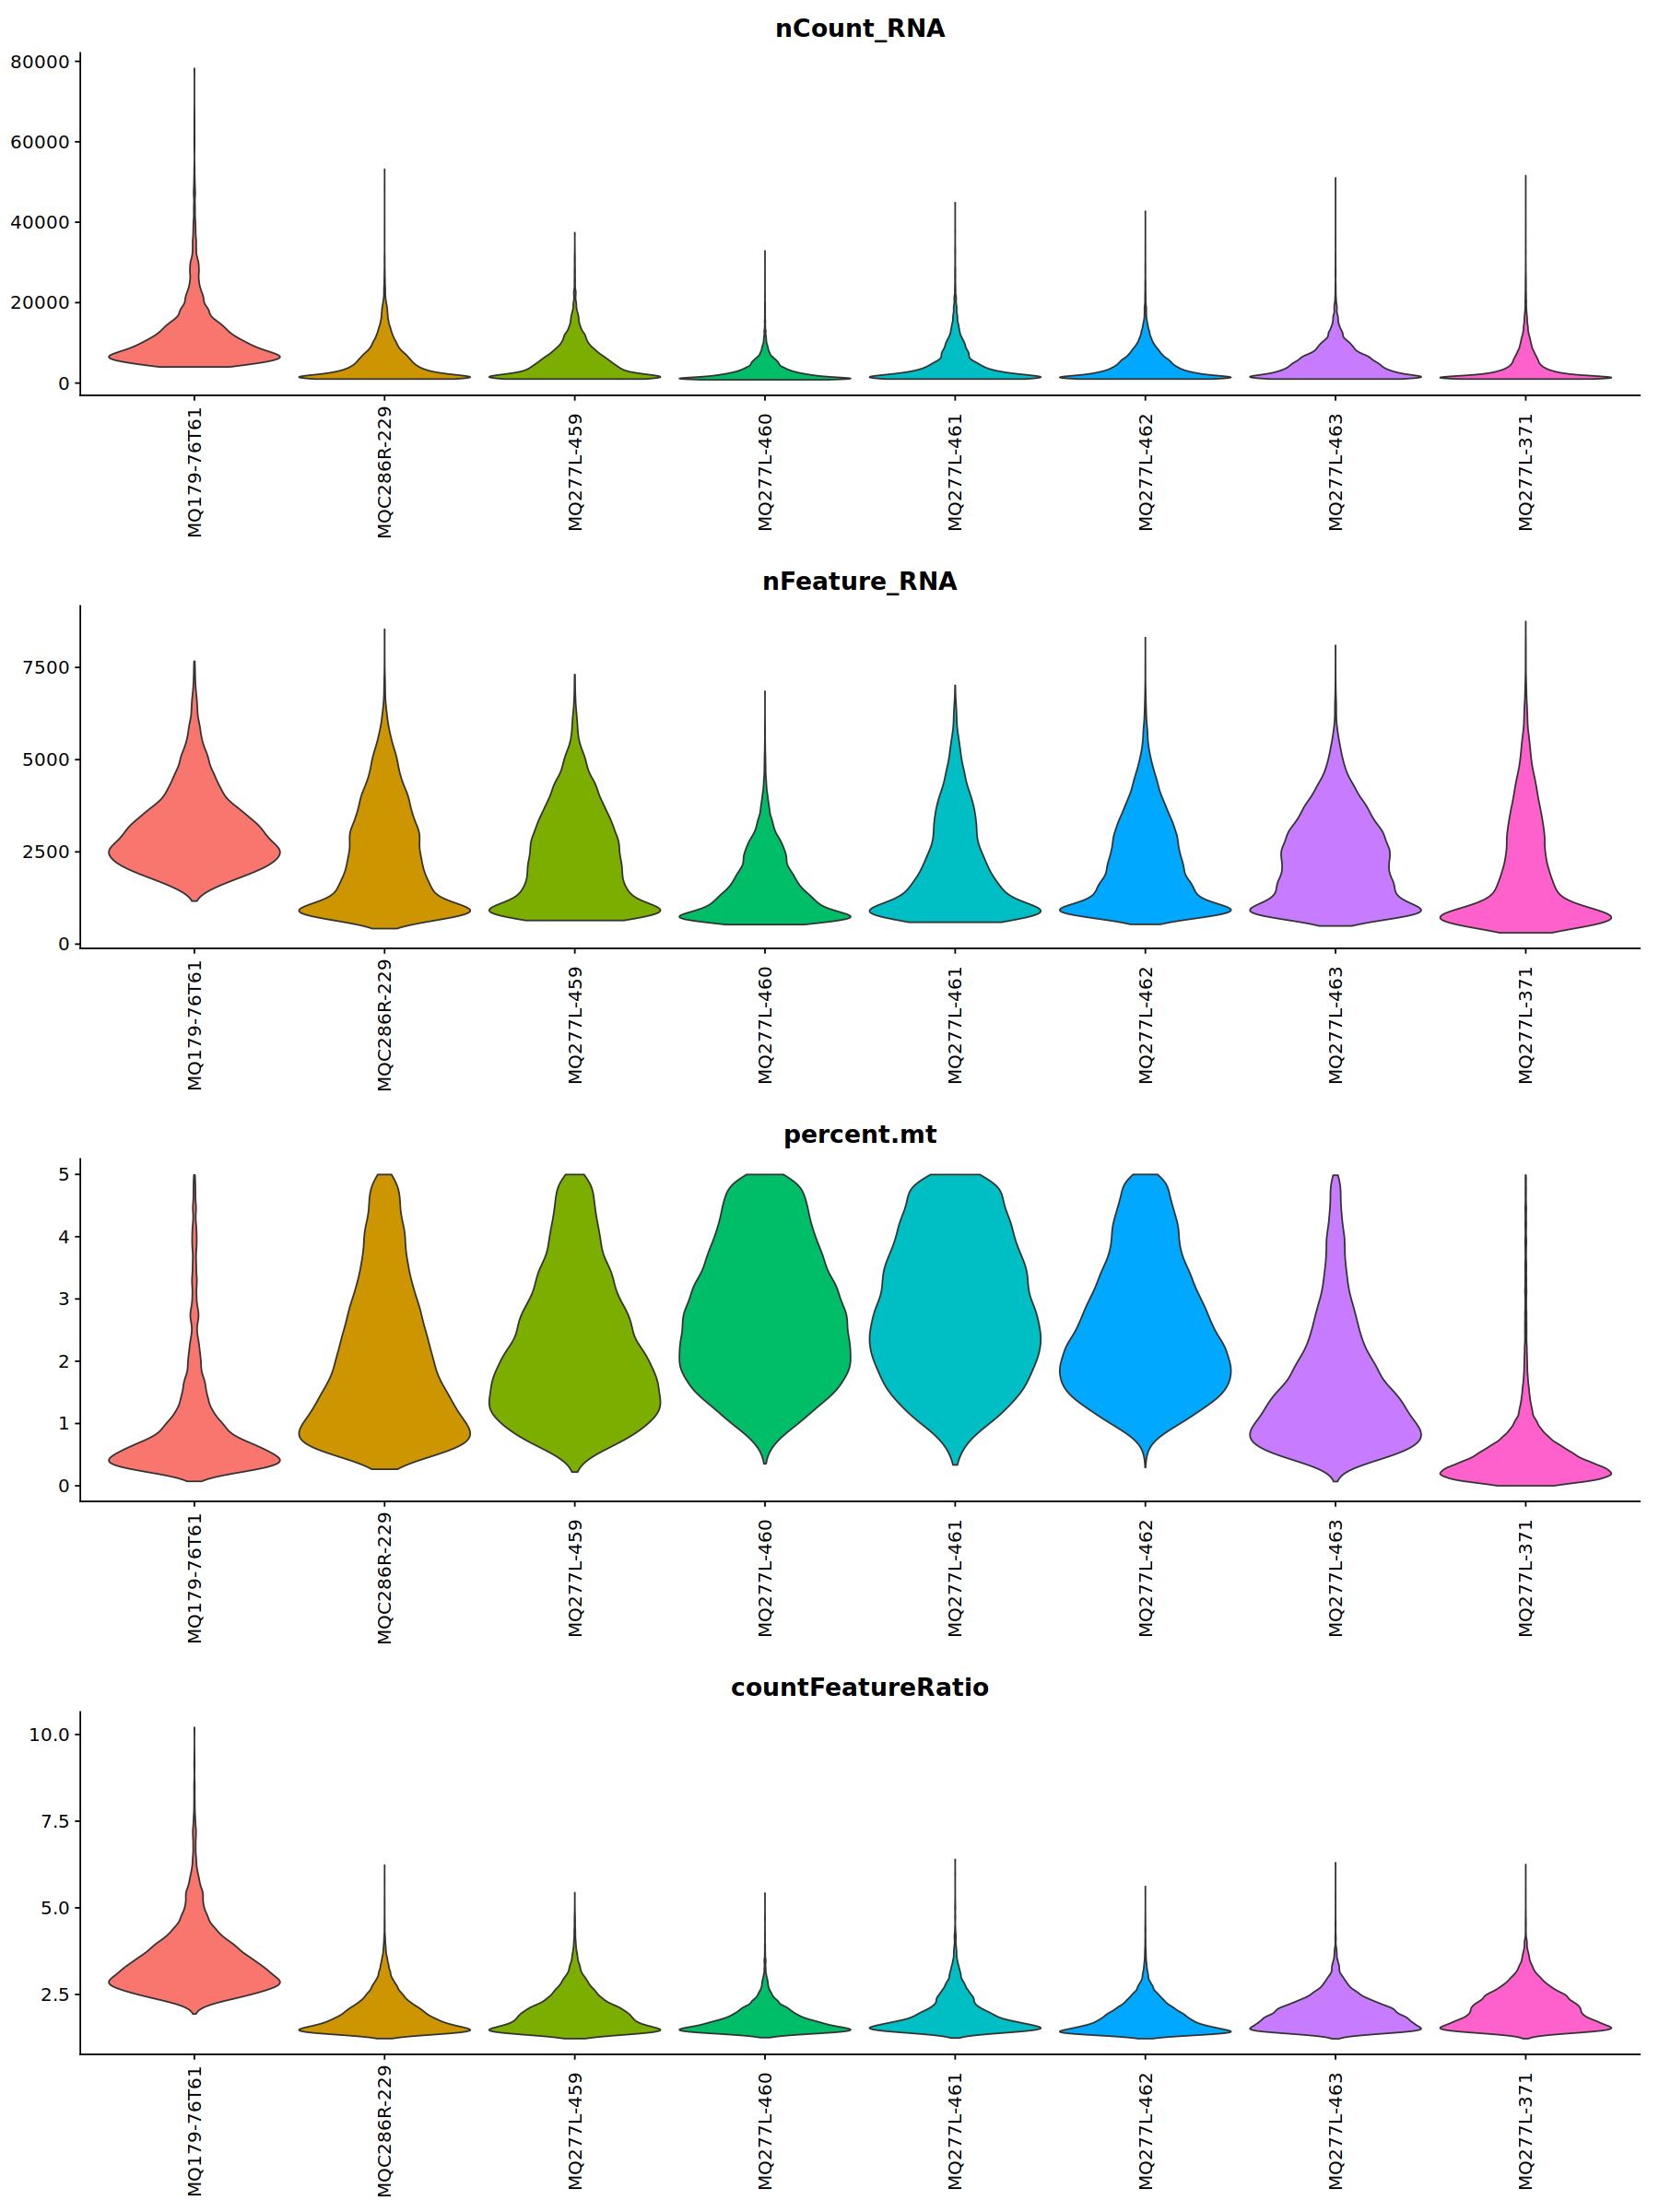

In [9]:
seurat$libId=seurat$group

Idents(seurat) = "libId"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

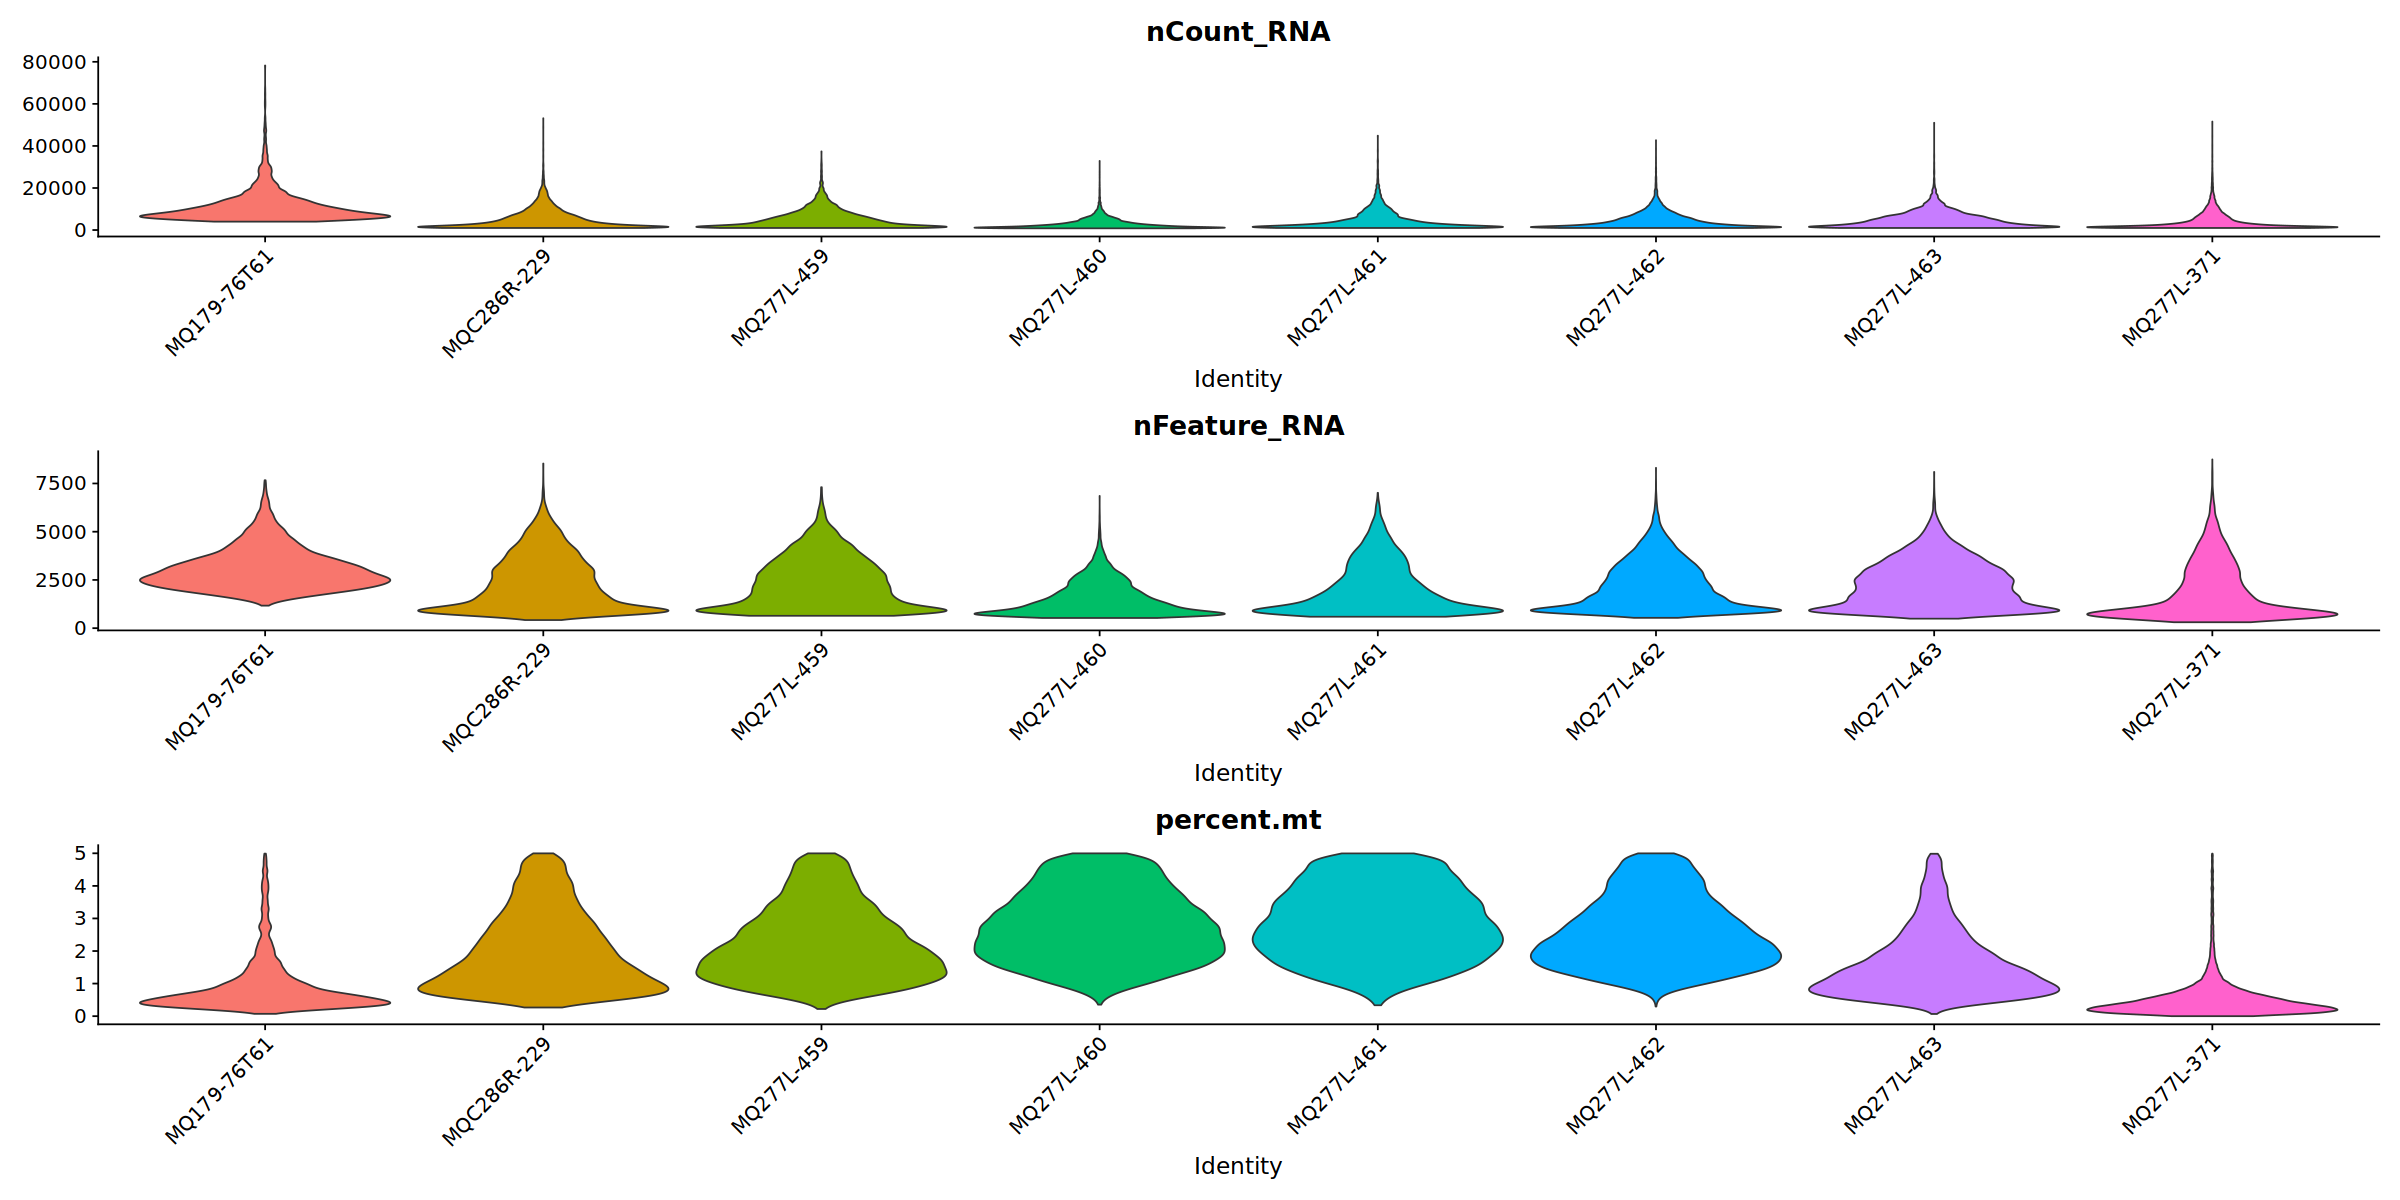

In [10]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "libId"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

In [11]:
seurat

An object of class Seurat 
23291 features across 75816 samples within 1 assay 
Active assay: RNA (23291 features, 0 variable features)

In [ ]:

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse', "/mouse_snrna_all_soupX_fil300_SCT_0619_0524_anno_SCT.rds"))


In [12]:
#更新版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/amygdala_snrna_all_soupX_fil_sample3.rds')



In [ ]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))
options(future.globals.maxSize= 891289600 * 160)

classFiltSeurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/amygdala_snrna_all_soupX_fil_sample3.rds')

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/amygdala_snrna_all_soupX_fil300_sample3_SCT.rds'))







In [ ]:
#!/bin/bash
#SBATCH -e /home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/err
#SBATCH -o /home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/out
#SBATCH -J 22222222222222
#SBATCH -p pro
#SBATCH --mem 500000
#SBATCH -n 2

Rscript /home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/sct.R
